In [2]:
from doctest import DocFileCase
import yfinance as yf

# Choose an interval: '1d' (daily), '1wk' (weekly), '1mo' (monthly), etc.
interval = '1d'  # Change this to '1wk' or '1mo' as needed
symbol = "^GSPC"
# Download historical data for S&P 500 (^GSPC) with the chosen interval
df = yf.download(symbol, period="1y", interval=interval)

print(f"Downloaded S&P 500 data with interval: {interval}")

df


/tmp/ipykernel_13490/662239329.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, period="1y", interval=interval)
[*********************100%***********************]  1 of 1 completed

Downloaded S&P 500 data with interval: 1d


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2024-12-11,6084.189941,6092.589844,6060.149902,6060.149902,4269950000
2024-12-12,6051.250000,6079.680176,6051.250000,6074.290039,3678010000
2024-12-13,6051.089844,6078.580078,6035.770020,6068.169922,3584960000
2024-12-16,6074.080078,6085.189941,6059.140137,6063.790039,4391100000
2024-12-17,6050.609863,6057.680176,6035.189941,6052.549805,4544500000
...,...,...,...,...,...
2025-12-04,6857.120117,6866.470215,6827.120117,6866.470215,4872440000
2025-12-05,6870.399902,6895.779785,6858.290039,6866.319824,4944560000


In [2]:
from lib.line import Calculator


calculator = Calculator()






In [3]:
import pandas as pd
import numpy as np

# Calculate dots first (needed for 6-x methods)
dots_valid = calculator.calculate_dots(df, symbol)
print(f"Calculated {len(dots_valid)} valid dots")

# Start with a copy of the original dataframe
result_df = df.copy()

# Add dots column - merge with dots_valid
if isinstance(result_df.columns, pd.MultiIndex):
    # For MultiIndex, we need to handle it differently
    dots_series = pd.Series(index=df.index, dtype=float)
    dots_series.loc[dots_valid.index] = dots_valid['dots'].values
    result_df[('Dots', symbol)] = dots_series
else:
    dots_series = pd.Series(index=df.index, dtype=float)
    dots_series.loc[dots_valid.index] = dots_valid['dots'].values
    result_df['Dots'] = dots_series

# Define all resistance and support function names
line_functions = [
    ('5_2_resistance', calculator.get_5_2_resistance, False),
    ('5_2_support', calculator.get_5_2_support, False),
    ('5_1_resistance', calculator.get_5_1_resistance, False),
    ('5_1_support', calculator.get_5_1_support, False),
    ('5_3_resistance', calculator.get_5_3_resistance, False),
    ('5_3_support', calculator.get_5_3_support, False),
    ('5_9_resistance', calculator.get_5_9_resistance, False),
    ('5_9_support', calculator.get_5_9_support, False),
    ('6_1_resistance', calculator.get_6_1_resistance, True),
    ('6_1_support', calculator.get_6_1_support, True),
    ('6_5_resistance', calculator.get_6_5_resistance, True),
    ('6_5_support', calculator.get_6_5_support, True),
    ('6_7_resistance', calculator.get_6_7_resistance, True),
    ('6_7_support', calculator.get_6_7_support, True),
]

# Initialize columns for all resistance/support types
for col_name, _, _ in line_functions:
    if isinstance(result_df.columns, pd.MultiIndex):
        result_df[(col_name, symbol)] = np.nan
    else:
        result_df[col_name] = np.nan

# Initialize binary target column (1 if price goes up next, 0 if down)
if isinstance(result_df.columns, pd.MultiIndex):
    result_df[('price_up', symbol)] = np.nan
else:
    result_df['price_up'] = np.nan

# Get dots as Series for 6-x functions
if isinstance(dots_valid, pd.DataFrame):
    dots_series_for_calc = dots_valid['dots']
else:
    dots_series_for_calc = dots_valid

# Iterate through all valid indices (need at least 3 bars, so start from index 2)
num_rows = len(df)
print(f"\nCalculating resistances and supports for {num_rows - 2} indices...")

for idx in range(2, num_rows):
    # Use negative index to work from the end
    index = -(num_rows - idx)
    
    # Calculate all lines for this index
    for col_name, func, needs_dots in line_functions:
        try:
            if needs_dots:
                point_1, point_2 = func(df, dots_series_for_calc, symbol, index)
            else:
                point_1, point_2 = func(df, symbol, index)
            
            # Store point2 y-value if line exists
            if point_1 is not None and point_2 is not None:
                y_value = point_2[1]  # y-value of point2
                # Get the date index for this bar
                if isinstance(result_df.columns, pd.MultiIndex):
                    result_df.loc[df.index[idx], (col_name, symbol)] = y_value
                else:
                    result_df.loc[df.index[idx], col_name] = y_value
        except Exception as e:
            # Skip if calculation fails (bounds, etc.)
            pass

# Calculate binary target: 1 if price goes up next, 0 if down
# Get close prices
if isinstance(result_df.columns, pd.MultiIndex):
    close_col = result_df[('Close', symbol)]
else:
    close_col = result_df['Close']

# For each row, compare current close with next close
for idx in range(len(result_df) - 1):
    current_close = close_col.iloc[idx]
    next_close = close_col.iloc[idx + 1]
    
    # 1 if price goes up, 0 if down
    price_up_value = 1 if next_close > current_close else 0
    
    if isinstance(result_df.columns, pd.MultiIndex):
        result_df.iloc[idx, result_df.columns.get_loc(('price_up', symbol))] = price_up_value
    else:
        result_df.iloc[idx, result_df.columns.get_loc('price_up')] = price_up_value

# Last row will remain NaN (no next row to compare)

print("Calculation complete!")
print(f"\nResult DataFrame shape: {result_df.shape}")
print(f"\nColumns: {list(result_df.columns)}")
print(f"\nPrice up distribution:")
if isinstance(result_df.columns, pd.MultiIndex):
    print(result_df[('price_up', symbol)].value_counts())
else:
    print(result_df['price_up'].value_counts())
print(f"\nFirst few rows:")
print(result_df.head(10))
print(f"\nLast few rows:")
print(result_df.tail(10))
result_df

/tmp/ipykernel_2623/1037122791.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[np.float64(6065.601128472223) np.float64(6061.902180989583)
 np.float64(6061.034450954861) np.float64(6064.949978298611)
 np.float64(6062.892252604167) np.float64(6058.592230902777)
 np.float64(6019.167805989583) np.float64(5958.085557725694)
 np.float64(5913.833333333333) np.float64(5918.752170138889)
 np.float64(5962.408854166667) np.float64(6001.2421875)
 np.float64(6007.361111111111) np.float64(5969.062228732639)
 np.float64(5923.008897569444) np.float64(5892.25439453125)
 np.float64(5899.31884765625) np.float64(5930.007703993056)
 np.float64(5948.587782118056) np.float64(5941.971082899306)
 np.float64(5894.053331163194) np.float64(5854.914442274306)
 np.float64(5832.617784288194) np.float64(5864.902235243056)
 np.float64(5907.636664496527) np.float64(5959.837782118056)
 np.float64(5992.271104600694) np.float64(6040.

Calculated 248 valid dots

Calculating resistances and supports for 248 indices...
Calculation complete!

Result DataFrame shape: (250, 21)

Columns: [('Close', '^GSPC'), ('High', '^GSPC'), ('Low', '^GSPC'), ('Open', '^GSPC'), ('Volume', '^GSPC'), ('Dots', '^GSPC'), ('5_2_resistance', '^GSPC'), ('5_2_support', '^GSPC'), ('5_1_resistance', '^GSPC'), ('5_1_support', '^GSPC'), ('5_3_resistance', '^GSPC'), ('5_3_support', '^GSPC'), ('5_9_resistance', '^GSPC'), ('5_9_support', '^GSPC'), ('6_1_resistance', '^GSPC'), ('6_1_support', '^GSPC'), ('6_5_resistance', '^GSPC'), ('6_5_support', '^GSPC'), ('6_7_resistance', '^GSPC'), ('6_7_support', '^GSPC'), ('price_up', '^GSPC')]

Price up distribution:
(price_up, ^GSPC)
1.0    142
0.0    107
Name: count, dtype: int64

First few rows:
Price             Close         High          Low         Open      Volume  \
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC   
Date                                                          

Price,Close,High,Low,Open,Volume,Dots,5_2_resistance,5_2_support,5_1_resistance,5_1_support,...,5_3_support,5_9_resistance,5_9_support,6_1_resistance,6_1_support,6_5_resistance,6_5_support,6_7_resistance,6_7_support,price_up
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,...,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-06,6090.270020,6099.970215,6079.979980,6081.379883,3924830000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2024-12-09,6052.850098,6088.509766,6048.629883,6083.009766,4556460000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2024-12-10,6034.910156,6065.399902,6029.890137,6057.589844,4048410000,6065.601128,NaN,6017.279785,NaN,NaN,...,NaN,6097.039551,5997.289551,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2024-12-11,6084.189941,6092.589844,6060.149902,6060.149902,4269950000,6061.902181,NaN,6011.150391,NaN,NaN,...,NaN,6082.169922,5971.270508,6101.312120,NaN,6065.802355,NaN,6065.802355,NaN,0.0
2024-12-12,6051.250000,6079.680176,6051.250000,6074.290039,3678010000,6061.034451,6119.779785,NaN,6090.409668,NaN,...,NaN,6155.289551,6054.899902,NaN,6031.214518,NaN,6063.654460,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-01,6812.629883,6843.649902,6799.939941,6812.299805,4549370000,6822.648817,6870.279785,NaN,6855.629883,NaN,...,NaN,6917.849609,6808.060059,NaN,6738.002224,NaN,6769.112088,NaN,6769.112088,1.0
2025-12-02,6829.370117,6851.549805,6806.709961,6830.959961,4582290000,6829.283257,NaN,6780.129883,NaN,NaN,...,NaN,6867.549805,6749.020020,6845.357693,6801.647732,NaN,NaN,NaN,NaN,1.0


In [4]:
# Cell 4: Data Preparation for TensorFlow Model
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

print("Preparing data for TensorFlow model...")

# Extract feature columns (all except price_up)
if isinstance(result_df.columns, pd.MultiIndex):
    feature_cols = [col for col in result_df.columns if col[0] != 'price_up']
    target_col = ('price_up', symbol)
else:
    feature_cols = [col for col in result_df.columns if col != 'price_up']
    target_col = 'price_up'

# Create feature and target dataframes
X = result_df[feature_cols].copy()
y = result_df[target_col].copy()

# Remove rows where target is NaN
valid_mask = ~y.isna()
X = X[valid_mask]
y = y[valid_mask]

print(f"Shape after removing NaN targets: X={X.shape}, y={y.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Handle NaN values in features - fill with median for numeric columns
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print(f"Features after imputation: {X_imputed.shape}")
print(f"NaN count after imputation: {X_imputed.isna().sum().sum()}")

# Store for next cell
X_imputed, y

Preparing data for TensorFlow model...
Shape after removing NaN targets: X=(249, 20), y=(249,)
Target distribution:
(price_up, ^GSPC)
1.0    142
0.0    107
Name: count, dtype: int64
Features after imputation: (249, 20)
NaN count after imputation: 0


(Price             Close         High          Low         Open        Volume  \
 Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC         ^GSPC   
 Date                                                                           
 2024-12-06  6090.270020  6099.970215  6079.979980  6081.379883  3.924830e+09   
 2024-12-09  6052.850098  6088.509766  6048.629883  6083.009766  4.556460e+09   
 2024-12-10  6034.910156  6065.399902  6029.890137  6057.589844  4.048410e+09   
 2024-12-11  6084.189941  6092.589844  6060.149902  6060.149902  4.269950e+09   
 2024-12-12  6051.250000  6079.680176  6051.250000  6074.290039  3.678010e+09   
 ...                 ...          ...          ...          ...           ...   
 2025-11-28  6849.089844  6850.859863  6819.750000  6822.520020  2.558540e+09   
 2025-12-01  6812.629883  6843.649902  6799.939941  6812.299805  4.549370e+09   
 2025-12-02  6829.370117  6851.549805  6806.709961  6830.959961  4.582290e+09   
 2025-12-03  6849.720215  68

In [5]:
# Cell 5: Feature Scaling and Train/Test Split
# Convert to numpy arrays
X_array = X_imputed.values.astype(np.float32)
y_array = y.values.astype(np.float32)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_array)

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_array, 
    test_size=0.2, 
    random_state=42,
    stratify=y_array  # Maintain class distribution
)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nTraining target distribution:")
print(f"  Class 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"\nTest target distribution:")
print(f"  Class 0: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Class 1: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")

# Get number of features
n_features = X_train.shape[1]
print(f"\nNumber of features: {n_features}")

Training set: X_train=(199, 20), y_train=(199,)
Test set: X_test=(50, 20), y_test=(50,)

Training target distribution:
  Class 0: 86 (43.2%)
  Class 1: 113 (56.8%)

Test target distribution:
  Class 0: 21 (42.0%)
  Class 1: 29 (58.0%)

Number of features: 20


In [6]:
# Cell 6: Create TensorFlow Model Architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Clear any existing models
tf.keras.backend.clear_session()

# Create model
model = Sequential([
    Dense(128, activation='relu', input_shape=(n_features,)),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Display model summary
print("Model Architecture:")
model.summary()

Model Architecture:


/usr/local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,441 (52.50 KB)

 Non-trainable params: 384 (1.50 KB)

In [7]:
# Cell 7: Train the Model
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Train the model
print("Training model...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nTraining completed!")

Training model...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5327 - loss: 0.7422 - precision: 0.6250 - recall: 0.4425 - val_accuracy: 0.5400 - val_loss: 0.6932 - val_precision: 0.5882 - val_recall: 0.6897 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5226 - loss: 0.7806 - precision: 0.5918 - recall: 0.5133 - val_accuracy: 0.5000 - val_loss: 0.6991 - val_precision: 0.5500 - val_recall: 0.7586 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5427 - loss: 0.7495 - precision: 0.6100 - recall: 0.5398 - val_accuracy: 0.5000 - val_loss: 0.7034 - val_precision: 0.5500 - val_recall: 0.7586 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5578 - loss: 0.7210 - precision: 0.6263 - recall: 0.5487 - val_accuracy: 0.5000 - val_loss: 0.7040 - val_precision: 0.5476 - val_recall: 0.7931 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accura

MODEL EVALUATION RESULTS

--- Training Set ---
AUC-ROC Score: 0.5696

Classification Report:
              precision    recall  f1-score   support

  Price Down       0.48      0.29      0.36        86
    Price Up       0.59      0.76      0.66       113

    accuracy                           0.56       199
   macro avg       0.53      0.53      0.51       199
weighted avg       0.54      0.56      0.53       199


Confusion Matrix:
[[25 61]
 [27 86]]

--- Test Set ---
AUC-ROC Score: 0.5123

Classification Report:
              precision    recall  f1-score   support

  Price Down       0.44      0.33      0.38        21
    Price Up       0.59      0.69      0.63        29

    accuracy                           0.54        50
   macro avg       0.51      0.51      0.51        50
weighted avg       0.52      0.54      0.53        50


Confusion Matrix:
[[ 7 14]
 [ 9 20]]


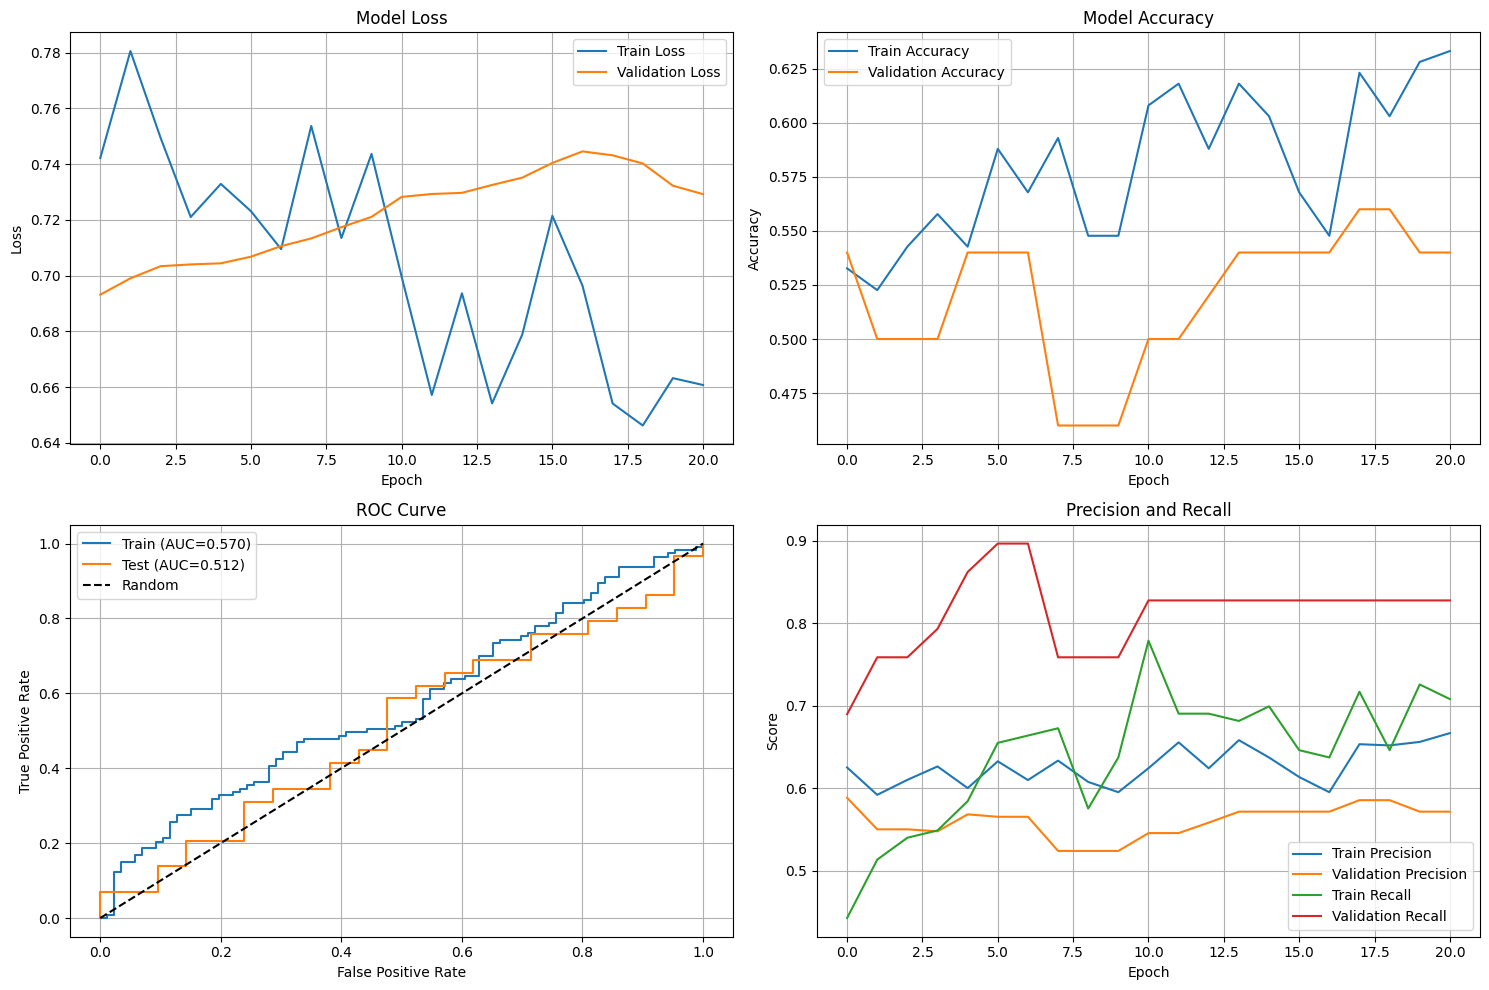

In [8]:
# Cell 8: Evaluate Model Performance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions
y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Convert probabilities to binary predictions
y_train_pred_binary = (y_train_pred > 0.5).astype(int).flatten()
y_test_pred_binary = (y_test_pred > 0.5).astype(int).flatten()

# Calculate metrics
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_test_pred)

print("=" * 60)
print("MODEL EVALUATION RESULTS")
print("=" * 60)

print("\n--- Training Set ---")
print(f"AUC-ROC Score: {train_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_train, y_train_pred_binary, target_names=['Price Down', 'Price Up']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_binary))

print("\n--- Test Set ---")
print(f"AUC-ROC Score: {test_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_binary, target_names=['Price Down', 'Price Up']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_binary))

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# ROC Curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
axes[1, 0].plot(fpr_train, tpr_train, label=f'Train (AUC={train_auc:.3f})')
axes[1, 0].plot(fpr_test, tpr_test, label=f'Test (AUC={test_auc:.3f})')
axes[1, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1, 0].set_title('ROC Curve')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Precision-Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision')
axes[1, 1].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Precision and Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)

In [9]:
y_train_pred

array([[0.515202  ],
       [0.488651  ],
       [0.47901404],
       [0.525077  ],
       [0.50861436],
       [0.5035895 ],
       [0.5106397 ],
       [0.5072502 ],
       [0.41195732],
       [0.50774145],
       [0.5207018 ],
       [0.42884824],
       [0.48126227],
       [0.59467316],
       [0.54598975],
       [0.49716517],
       [0.49328876],
       [0.5845425 ],
       [0.49807242],
       [0.4820341 ],
       [0.54457355],
       [0.5525846 ],
       [0.5063927 ],
       [0.518847  ],
       [0.5279703 ],
       [0.5057126 ],
       [0.5148971 ],
       [0.5048272 ],
       [0.6336061 ],
       [0.5346235 ],
       [0.5067271 ],
       [0.4713079 ],
       [0.5274628 ],
       [0.54148096],
       [0.5198675 ],
       [0.5499628 ],
       [0.5007813 ],
       [0.50573015],
       [0.51122135],
       [0.49764103],
       [0.49805745],
       [0.48599434],
       [0.4774507 ],
       [0.5295611 ],
       [0.5022769 ],
       [0.51131386],
       [0.5085068 ],
       [0.472

In [ ]:
# Cell 9: Make Predictions on Full Dataset
# Prepare full dataset for prediction
X_full = X_imputed.values.astype(np.float32)
X_full_scaled = scaler.transform(X_full)

# Make predictions
predictions = model.predict(X_full_scaled, verbose=0)
predictions_binary = (predictions > 0.5).astype(int).flatten()

# Create results dataframe
results_df = pd.DataFrame({
    'Date': X_imputed.index,
    'Actual_price_up': y.values,
    'Predicted_probability': predictions.flatten(),
    'Predicted_price_up': predictions_binary
})

# Add original features for reference
for col in X_imputed.columns:
    results_df[col] = X_imputed[col].values

print("Predictions on full dataset:")
print(results_df[['Date', 'Actual_price_up', 'Predicted_probability', 'Predicted_price_up']].head(10))
print("\n...")
print(results_df[['Date', 'Actual_price_up', 'Predicted_probability', 'Predicted_price_up']].tail(10))

# Calculate accuracy on full dataset (excluding NaN targets)
valid_predictions = results_df['Actual_price_up'].notna()
if valid_predictions.sum() > 0:
    full_accuracy = (results_df.loc[valid_predictions, 'Actual_price_up'] == 
                     results_df.loc[valid_predictions, 'Predicted_price_up']).mean()
    print(f"\nFull Dataset Accuracy: {full_accuracy:.4f} ({full_accuracy*100:.2f}%)")

results_df